In [95]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
import statsmodels.api as sm

folder_path = "jatos_results_20240125"
metadata_path = "jatos_results_20240125/metadata.json"

mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 16

In [369]:
# create meta dataset: prolific_id, duration in each component, age, sex  
with open(metadata_path, 'r') as file:
            metadata = json.load(file)

study_result = metadata['data'][0]['studyResults']
comp_cols = ['component_duration_' + str(i+1) for i in range(len(study_result[0]['componentResults']))]
meta_cols = ['worker_id','prolific_id','status','duration','duration_second'] + comp_cols

dict_meta = {key: [] for key in meta_cols}

for w in range(len(study_result)):
    if study_result[w]['studyState'] == 'FINISHED':
        dict_meta['worker_id'] += [str(study_result[w]['workerId'])]
        dict_meta['prolific_id'] += [study_result[w]['urlQueryParameters']['PROLIFIC_PID']]
        dict_meta['status'] += [study_result[w]['studyState']]
        dict_meta['duration'] += [study_result[w]['duration']]
        time_object = datetime.strptime(study_result[w]['duration'], "%H:%M:%S")
        duration_second = time_object.hour * 3600 + time_object.minute * 60 + time_object.second
        dict_meta['duration_second'] += [duration_second]
        for i in range(len(comp_cols)):
            dict_meta[comp_cols[i]] += [study_result[w]['componentResults'][i]['duration']]

df_meta = pd.DataFrame(dict_meta)

df_demographic = pd.read_csv('prolific_demographic.csv')[['Participant id','Age','Sex']].\
                            rename(columns={'Participant id':'prolific_id',
                                            'Age':'age','Sex':'sex'})

df_meta = pd.merge(df_meta,df_demographic,on='prolific_id')
df_meta.to_csv('meta_data.csv')

In [13]:
# create main datasets
df_consistency = pd.DataFrame() # consistency check questions
df_time = pd.DataFrame() # fill-in-the-blank questions
df_peli = pd.DataFrame() # preference for earlier vs later income (PELI) task

def read_comp_result(file_path,df_consistency,df_time,df_peli):
    with open(file_path, 'r') as file:
            data = json.load(file)

    if 'task' in data:
        if data['task'] == 'consistency-check':
            df_consistency_new = pd.DataFrame(data['choice'])
            df_consistency_new['worker_id'] = data['worker_id']
            df_consistency_new['screen_width'] = data['screen_width']
            df_consistency = pd.concat([df_consistency, df_consistency_new], ignore_index=True)
        elif data['task'] == 'blank-filling':
            df_time_new = pd.DataFrame(data['choice'])
            df_time_new['worker_id'] = data['worker_id']
            df_time_new['prolific_id'] = data['url']['PROLIFIC_PID']
            df_time = pd.concat([df_time, df_time_new], ignore_index=True)
        elif data['task'] == 'income-earlier-later':
            url = data.pop('url')
            df_peli_new = pd.DataFrame(data,index=[data['worker_id']])
            df_peli_new['prolific_id'] = url['PROLIFIC_PID']
            df_peli = pd.concat([df_peli, df_peli_new], ignore_index=True)

    
    return df_consistency,df_time,df_peli


for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith("data.txt"):
                    file_path = os.path.join(root, file)
                    print(file_path)
                    df_consistency,df_time,df_peli = read_comp_result(file_path,df_consistency,df_time,df_peli)

df_consistency.insert(0, 'worker_id', df_consistency.pop('worker_id'))
df_time.insert(0, 'worker_id', df_time.pop('worker_id'))
df_peli.insert(0, 'worker_id', df_peli.pop('worker_id'))

jatos_results_20240125\study_result_400685\comp-result_551812\data.txt
jatos_results_20240125\study_result_400685\comp-result_551816\data.txt
jatos_results_20240125\study_result_400685\comp-result_551823\data.txt
jatos_results_20240125\study_result_400685\comp-result_551843\data.txt
jatos_results_20240125\study_result_400686\comp-result_551819\data.txt
jatos_results_20240125\study_result_400686\comp-result_551821\data.txt
jatos_results_20240125\study_result_400686\comp-result_551828\data.txt
jatos_results_20240125\study_result_400686\comp-result_551837\data.txt
jatos_results_20240125\study_result_400687\comp-result_551822\data.txt
jatos_results_20240125\study_result_400687\comp-result_551826\data.txt
jatos_results_20240125\study_result_400687\comp-result_551835\data.txt
jatos_results_20240125\study_result_400687\comp-result_551854\data.txt
jatos_results_20240125\study_result_400688\comp-result_551827\data.txt
jatos_results_20240125\study_result_400688\comp-result_551831\data.txt
jatos_

In [18]:
# consistency check
df_check = pd.merge(df_consistency,df_time,on=['worker_id','front_amount','backend_amount'])

def check_fail(row):
    '''
    In any question, if choosing two-reward sequence, indifference point should not be smaller than the given single-reward sequence;
    if choosing single-reward sequence, indifference point should not be larger than the given single-reward sequence.
    '''

    if row['sequence_single_choice'] == 'sequence':
        return row['indiff_point'] < row['single_amount']
    elif row['sequence_single_choice'] == 'single':
        return row['indiff_point'] > row['single_amount']
    else:
        return True

df_check['fail_check'] = df_check.apply(check_fail, axis=1)

df_check_result = df_check.groupby('worker_id')['fail_check'].sum() > 0
fail_consistency_check = df_check_result[df_check_result].index.unique()
print('Number of participants who fail consistency check:',len(fail_consistency_check))
print('Worker IDs to be excluded:',list(fail_consistency_check))

Number of participants who fail consistency check: 40
Worker IDs to be excluded: ['434924', '434925', '434933', '434938', '434939', '434948', '434950', '434951', '434956', '434965', '434970', '434973', '434975', '434987', '434991', '434994', '435006', '435007', '435012', '435014', '435023', '435025', '435034', '435037', '435044', '435050', '435051', '435061', '435071', '435078', '435082', '435085', '435088', '435091', '435094', '435102', '435109', '435112', '435125', '435126']


In [318]:
# merge all answers into one dataset
df_time_valid = df_time[~df_time['worker_id'].isin(fail_consistency_check)]
df_time_valid['value_surplus'] = df_time_valid['indiff_point'] - df_time_valid['front_amount']
df_time_valid = pd.merge(df_time_valid,
                         df_peli[['worker_id','choice_label','choice_value','response_time_mel']],on='worker_id'). \
                    sort_values(['worker_id','q_id'])

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_15308\3754391043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_valid['value_surplus'] = df_time_valid['indiff_point'] - df_time_valid['front_amount']


In [319]:
# cluster analysis: divide data to two groups using k-means clustering
df_time_valid['reward'] = df_time_valid.apply(lambda x: 'reward_' + x['seq_length'].split()[0] +'_' + str(x['front_amount']),axis=1)
df_time_pivot = df_time_valid.pivot(index='worker_id', columns='reward', values='value_surplus')

kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(df_time_pivot.values)

# cluster results
df_time_pivot['label'] = kmeans.labels_
cols = ['label'] + [col for col in df_time_pivot if col != 'label']
df_time_pivot = df_time_pivot[cols].reset_index()
print('Number of participants in each cluster:',[(df_time_pivot['label'] == 0).sum(),(df_time_pivot['label'] == 1).sum()])

# save the data
df_time_label = pd.merge(df_time_valid,df_time_pivot[['worker_id','label']],on=['worker_id'])
df_time_label.to_csv('valid_sequence_data')

Number of participants in each cluster: [54, 103]


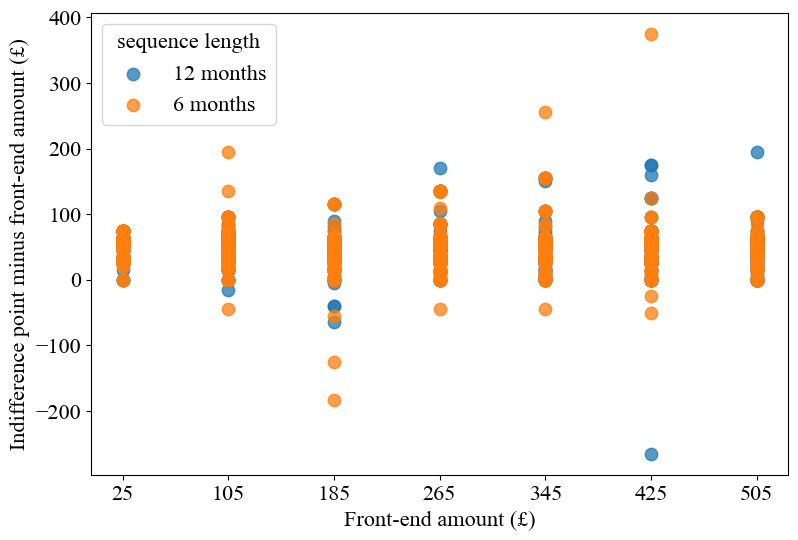

In [320]:
# Plot: check outliers
df_plot = df_time_valid.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
seq_length_list = df_plot['seq_length'].unique()
front_amount_list = df_plot['front_amount'].unique()

plt.figure(figsize=(9, 6))
for t in seq_length_list:
    tab_plot = df_time_valid[df_time_valid['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['value_surplus'],label=t,alpha=0.75,s=80)

# Add title and labels
plt.xlabel('Front-end amount (£)')
plt.ylabel('Indifference point minus front-end amount (£)')
plt.xticks(front_amount_list)
plt.legend(loc=2,title='sequence length')

C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

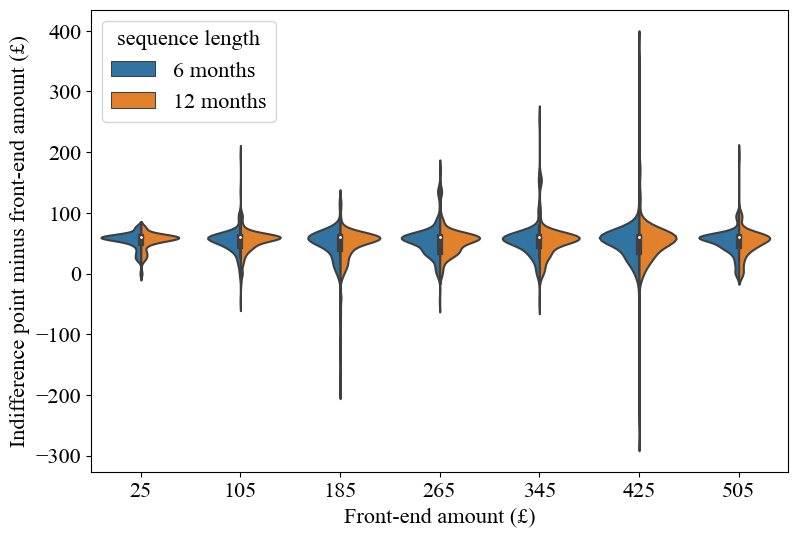

In [321]:
# Create the violin plot
plt.figure(figsize=(9, 6))
sns.violinplot(x='front_amount', y='value_surplus', hue='seq_length', data=df_time_valid, split=True)
plt.xlabel('Front-end amount (£)')
plt.ylabel('Indifference point minus front-end amount (£)')
plt.legend(loc=2,title='sequence length')

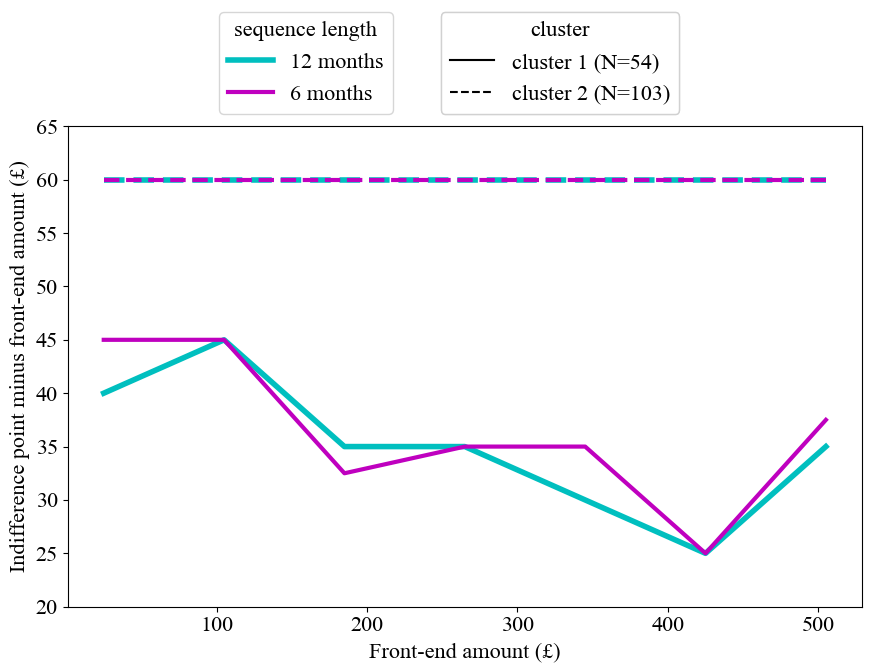

In [322]:
df_plot_median = df_time_label.groupby(['seq_length','front_amount','label'])['value_surplus'].median().to_frame().reset_index()

color_list = ['c','m']
linewidth_list = [4,3]

fig,ax  = plt.subplots(2, 1, figsize=(9, 7), gridspec_kw={'height_ratios': [0.15, 0.85]})

for t in range(len(seq_length_list)):
        tab_plot_0 = df_plot_median[(df_plot_median['seq_length'] == seq_length_list[t]) & (df_plot_median['label'] == 0)]
        tab_plot_1 = df_plot_median[(df_plot_median['seq_length'] == seq_length_list[t]) & (df_plot_median['label'] == 1)]
        ax[1].plot(tab_plot_0['front_amount'],tab_plot_0['value_surplus'],ls='solid',c=color_list[t],lw=linewidth_list[t])
        ax[1].plot(tab_plot_1['front_amount'],tab_plot_1['value_surplus'],ls='dashed',c=color_list[t],lw=linewidth_list[t])

ax[1].plot(np.NaN,np.NaN,ls='solid',c='black')
ax[1].plot(np.NaN,np.NaN,ls='dashed',c='black')


plt.yticks(np.arange(20,70,step=5))
plt.xlabel('Front-end amount (£)')
plt.ylabel('Indifference point minus front-end amount (£)')


lines = ax[1].get_lines()
legend1 = plt.legend([lines[i] for i in [0,2]], ["12 months", "6 months"], title='sequence length',
                     loc='upper center', bbox_to_anchor=(0.3, 1.26))
legend2 = plt.legend([lines[i] for i in [4,5]], ["cluster 1 (N=54)", "cluster 2 (N=103)"], title='cluster',
                     loc='upper center', bbox_to_anchor=(0.62, 1.26))
ax[1].add_artist(legend1)
ax[1].add_artist(legend2)

ax[0].axis('off')
plt.tight_layout()


In [331]:
np.ceil(df_time_label.shape[0] * 0.005 / 2)

6.0

In [340]:
df_time_label['front_amount_6m'] = df_time_label['front_amount'] * (df_time_label['seq_length'] == '6 months')
df_time_label['front_amount_12m'] = df_time_label['front_amount'] * (df_time_label['seq_length'] == '12 months')
df_time_label['front_amount_6m_0'] = df_time_label['front_amount_6m']  * (df_time_label['label'] == 0)
df_time_label['front_amount_6m_1'] = df_time_label['front_amount_6m']  * (df_time_label['label'] == 1)
df_time_label['front_amount_12m_0'] = df_time_label['front_amount_12m']  * (df_time_label['label'] == 0)
df_time_label['front_amount_12m_1'] = df_time_label['front_amount_12m']  * (df_time_label['label'] == 1)

ratio_outliers = 0.005
rule_out_index = int(np.ceil(df_time_label.shape[0] * ratio_outliers / 2) - 1)
upper_bound = df_time_label['value_surplus'].sort_values(ascending=False).to_list()[rule_out_index]
lower_bound = df_time_label['value_surplus'].sort_values().to_list()[rule_out_index]
df_filtered = df_time_label[(df_time_label['value_surplus'] > lower_bound) & (df_time_label['value_surplus'] < upper_bound)]

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_value']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_value']

y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_baseline]).astype(float)

reg_lm_pool = sm.OLS(endog = y , exog = X).fit()
reg_lm_pool.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_surplus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.147
Date:                Mon, 29 Jan 2024   Prob (F-statistic):              0.329
Time:                        21:46:33   Log-Likelihood:                -9769.1
No. Observations:                2186   AIC:                         1.955e+04
Df Residuals:                    2182   BIC:                         1.957e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               54.0742      1.215     44.516      0.000      51.692      56.456
front_amount_6m     -0.0049      0.003     -1.552      0.121      -0.011       0.001
front_amount_12m    -0.0051      0.003     -1.609      0.108      -0.011       0.001
choice_value        -0.5628      1.087     -0.518      0.605      -2.695       1.569
==============================================================================
Omnibus:                      240.214   Durbin-Watson:                   0.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2058.215
Skew:                           0.085   Prob(JB):                         0.00
Kurtosis:                       7.751   Cond. No.                         728.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [342]:
reg_lm_fe = sm.MixedLM(endog = y , exog = X, groups = df_filtered['worker_id']).fit()
reg_lm_fe.summary()

d:\Python\lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM Dependent Variable: value_surplus
No. Observations:  2186    Method:             REML         
No. Groups:        157     Scale:              161.8588     
Min. group size:   11      Log-Likelihood:     -8922.9813   
Max. group size:   14      Converged:          Yes          
Mean group size:   13.9                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
const             54.025    2.976 18.156 0.000 48.193 59.857
front_amount_6m   -0.005    0.002 -2.576 0.010 -0.009 -0.001
front_amount_12m  -0.005    0.002 -2.540 0.011 -0.009 -0.001
choice_value      -0.473    3.337 -0.142 0.887 -7.013  6.067
Group Var        291.173    2.806                           
============================================================

"""

In [343]:
reg_rlm_pool = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit()
reg_rlm_pool.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          value_surplus   No. Observations:                 2186
Model:                            RLM   Df Residuals:                     2182
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        21:47:14                                         
No. Iterations:                    41                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               57.1640      0.705     81.079      0.000      55.782      58.546
front_amount_6m     -0.0038      0.002     -2.045      0.041      -0.007      -0.000
front_amount_12m    -0.0049      0.002     -2.655      0.008      -0.009      -0.001
choice_value        -1.5336      0.631     -2.430      0.015      -2.770      -0.297
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [344]:
df_dummy = pd.concat([df_time_label,pd.get_dummies(df_time_label['worker_id'], prefix='worker_id')],axis=1)
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]

y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)

reg_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit()
reg_rlm_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          value_surplus   No. Observations:                 2198
Model:                            RLM   Df Residuals:                     2039
Method:                          IRLS   Df Model:                          158
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        21:47:45                                         
No. Iterations:                    50                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               50.7362   3.97e-07   1.28e+08      0.000      50.736      50.736
front_amount_6m  -6.774e-09   1.09e-09     -6.242      0.000    -8.9e-09   -4.65e-09
front_amount_12m -9.659e-09   1.09e-09     -8.901      0.000   -1.18e-08   -7.53e-09
choice_value         1.9538    3.5e-07   5.58e+06      0.000       1.954       1.954
worker_id_434923     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434926     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434927    12.3100   1.92e-06    6.4e+06      0.000      12.310      12.310
worker_id_434928   -25.7362   1.91e-06  -1.35e+07      0.000     -25.736     -25.736
worker_id_434930     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434931     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434932    61.0752   1.92e-06   3.17e+07      0.000      61.075      61.075
worker_id_434934    -0.5331   1.92e-06  -2.77e+05      0.000      -0.533      -0.533
worker_id_434935    -7.6900   1.92e-06     -4e+06      0.000      -7.690      -7.690
worker_id_434936   -24.2086   1.92e-06  -1.26e+07      0.000     -24.209     -24.209
worker_id_434937   -50.7362   1.91e-06  -2.66e+07      0.000     -50.736     -50.736
worker_id_434940     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434941     9.2638   1.91e-06   4.86e+06      0.000       9.264       9.264
worker_id_434942   -12.6900   1.92e-06  -6.59e+06      0.000     -12.690     -12.690
worker_id_434943    17.3100   1.92e-06   8.99e+06      0.000      17.310      17.310
worker_id_434944     9.2638   1.91e-06   4.86e+06      0.000       9.264       9.264
worker_id_434945     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434946   -15.7468   1.92e-06  -8.18e+06      0.000     -15.747     -15.747
worker_id_434947     9.2638   1.91e-06   4.86e+06      0.000       9.264       9.264
worker_id_434949   -14.6344   1.92e-06   -7.6e+06      0.000     -14.634     -14.634
worker_id_434952     9.2638   1.91e-06   4.86e+06      0.000       9.264       9.264
worker_id_434953     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434954     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434955     9.2638   1.91e-06   4.86e+06      0.000       9.264       9.264
worker_id_434957     2.3100   1.92e-06    1.2e+06      0.000       2.310       2.310
worker_id_434958     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434959     2.3100   1.92e-06    1.2e+06      0.000       2.310       2.310
worker_id_434960    24.2638   1.91e-06   1.27e+07      0.000      24.264      24.264
worker_id_434961     7.3100   1.92e-06    3.8e+06      0.000       7.310       7.310
worker_id_434962     9.

In [345]:
y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_label]).astype(float)

reg_lm_fe_2 = sm.MixedLM(endog = y , exog = X, groups = df_filtered['worker_id']).fit()
reg_lm_fe_2.summary()

d:\Python\lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:             MixedLM  Dependent Variable:  value_surplus
No. Observations:  2186     Method:              REML         
No. Groups:        157      Scale:               159.6313     
Min. group size:   11       Log-Likelihood:      -8888.9293   
Max. group size:   14       Converged:           Yes          
Mean group size:   13.9                                       
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
const               54.016    2.488 21.710 0.000 49.139 58.892
front_amount_6m_0   -0.025    0.003 -7.814 0.000 -0.031 -0.019
front_amount_12m_0  -0.028    0.003 -8.577 0.000 -0.034 -0.021
front_amount_6m_1    0.006    0.002  2.435 0.015  0.001  0.010
front_amount_12m_1   0.007    0.002  3.032 0.002  0.003  0.012
choice_value        -0.461    2.777 -0.166 0.868 -5.904  4.981
Group Var          198.202    2.077                           
==============================================================

"""

In [347]:
reg_cols_dummy = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]

y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)

reg_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit()
reg_rlm_fe_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          value_surplus   No. Observations:                 2198
Model:                            RLM   Df Residuals:                     2037
Method:                          IRLS   Df Model:                          160
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Jan 2024                                         
Time:                        21:48:37                                         
No. Iterations:                    50                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 51.9536      0.134    388.587      0.000      51.692      52.216
front_amount_6m_0     -0.0142      0.001    -22.807      0.000      -0.015      -0.013
front_amount_12m_0    -0.0189      0.001    -30.251      0.000      -0.020      -0.018
front_amount_6m_1     -0.0002      0.000     -0.547      0.584      -0.001       0.001
front_amount_12m_1    -0.0004      0.000     -0.845      0.398      -0.001       0.001
choice_value           2.3324      0.118     19.765      0.000       2.101       2.564
worker_id_434923       5.9366      0.652      9.109      0.000       4.659       7.214
worker_id_434926       5.7973      0.652      8.895      0.000       4.520       7.075
worker_id_434927      10.7973      0.652     16.567      0.000       9.520      12.075
worker_id_434928     -22.8019      0.653    -34.917      0.000     -24.082     -21.522
worker_id_434930       5.7973      0.652      8.895      0.000       4.520       7.075
worker_id_434931       5.7973      0.652      8.895      0.000       4.520       7.075
worker_id_434932      58.6722      0.652     90.023      0.000      57.395      59.950
worker_id_434934      -1.7928      0.652     -2.751      0.006      -3.070      -0.515
worker_id_434935      -4.8848      0.660     -7.406      0.000      -6.178      -3.592
worker_id_434936     -20.4977      0.660    -31.078      0.000     -21.790     -19.205
worker_id_434937     -48.9208      0.653    -74.913      0.000     -50.201     -47.641
worker_id_434940       5.7973      0.652      8.895      0.000       4.520       7.075
worker_id_434941       8.2713      0.645     12.822      0.000       7.007       9.536
worker_id_434942     -11.2254      0.660    -17.020      0.000     -12.518      -9.933
worker_id_434943      15.8423      0.652     24.308      0.000      14.565      17.120
worker_id_434944       7.9923      0.645     12.389      0.000       6.728       9.257
worker_id_434945       5.7973      0.652      8.895      0.000       4.520       7.075
worker_id_434946     -12.3273      0.660    -18.690      0.000     -13.620     -11.035
worker_id_434947       8.1296      0.645     12.602      0.000       6.865       9.394
worker_id_434949     -11.2812      0.660    -17.104      0.000     -12.574      -9.989
worker_id_434952       8.2666      0.645     12.815      0.000       7.002       9.531
worker_id_434953      10.5445      0.660     15.987      0.000       9.252      11.837
worker_id_434954       5.7973      0.652      8.895      0.000       4.520       7.075
worker_id_434955       8.1296      0.645     12.602      0.000       6.865       9.394
worker_id_434957      -0.1418      0.652     -0.218      0.828      -1.419       1.136
worker_id_434958       5.7973      0.652      8.895      0.000       4.520       7.075
worker_id_434959       1.0418      0.6

Text(0.5, 0, 'Number of questions answered with total money heuristic')

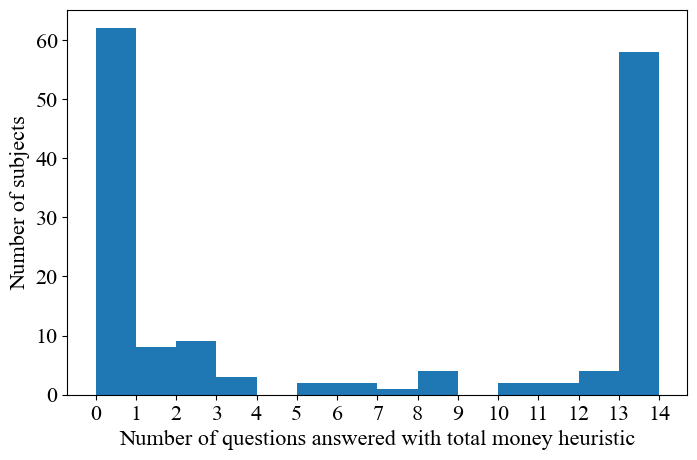

In [368]:
df_time_valid['total_money_heuristic'] = df_time_valid['value_surplus'] == 60
plt.figure(figsize=(8,5))
plt.hist(df_time_valid.groupby('worker_id')['total_money_heuristic'].sum(),bins=14)
plt.xticks(np.arange(15))
plt.ylabel('Number of subjects')
plt.xlabel('Number of questions answered with total money heuristic')

Text(0, 0.5, 'indifference point minus front-end amount (£)')

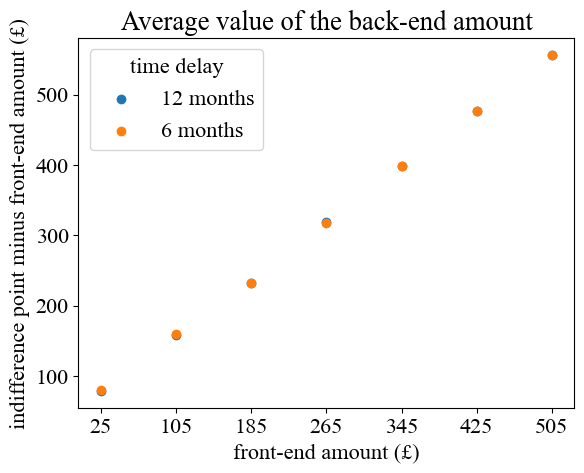

In [350]:
df_plot = df_time_valid.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
front_amount_list = df_plot['front_amount'].unique()

for t in seq_length_list:
    tab_plot = df_plot[df_plot['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['indiff_point'],label=t)

plt.title('Average value of the back-end amount')
plt.legend(loc='best',title='time delay')
plt.xticks(front_amount_list)
# plt.yticks(np.arange(30,55,step=5))
plt.xlabel('front-end amount (£)')
plt.ylabel('indifference point minus front-end amount (£)')